In [1]:
# We import finspark to make pyspark importable as a regular library.
import findspark
findspark.init() 

import pyspark # Import pyspark
from pyspark.sql import SparkSession # Import spark session class
from pyspark.sql.functions import isnan, when, count, col # Import some general useful pyspark functions
import pandas as pd # Import pandas for any data manipulation and visualisations
import matplotlib.pyplot as plt # Import matplotlib for data viz
import seaborn as sns # Import seaborn also for data viz

# Create instance of the class
spark = SparkSession.builder.getOrCreate()

# Creates wider cells so we can view more info when displaying data
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
# We need to tell spark that the schema should be “inferred” from the data,
# but also, we want to tell it to use the headers from the columns
df = spark.read.csv("Task_1_dataset/nuclear_plants_small_dataset.csv", inferSchema=True,header=True)

In [3]:
# Look at the basic structure of the data
df.printSchema()

root
 |-- Status: string (nullable = true)
 |-- Power_range_sensor_1: double (nullable = true)
 |-- Power_range_sensor_2: double (nullable = true)
 |-- Power_range_sensor_3 : double (nullable = true)
 |-- Power_range_sensor_4: double (nullable = true)
 |-- Pressure _sensor_1: double (nullable = true)
 |-- Pressure _sensor_2: double (nullable = true)
 |-- Pressure _sensor_3: double (nullable = true)
 |-- Pressure _sensor_4: double (nullable = true)
 |-- Vibration_sensor_1: double (nullable = true)
 |-- Vibration_sensor_2: double (nullable = true)
 |-- Vibration_sensor_3: double (nullable = true)
 |-- Vibration_sensor_4: double (nullable = true)



In [4]:
# We can see in the column names there are random spaces that could cause key errors in later analysis
from pyspark.sql.functions import col # Import col function to select a specfic column from dataframe

# Replace space in all columns of the dataframe with nothing
df = df.select([col(column).alias(column.replace(' ', '')) for column in df.columns])

In [5]:
# Find num of null values for each column
df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0-------------------
 Status               | 0   
 Power_range_sensor_1 | 0   
 Power_range_sensor_2 | 0   
 Power_range_sensor_3 | 0   
 Power_range_sensor_4 | 0   
 Pressure_sensor_1    | 0   
 Pressure_sensor_2    | 0   
 Pressure_sensor_3    | 0   
 Pressure_sensor_4    | 0   
 Vibration_sensor_1   | 0   
 Vibration_sensor_2   | 0   
 Vibration_sensor_3   | 0   
 Vibration_sensor_4   | 0   



In [6]:
# Converts current pyspark data frame to pandas to be able to calculate agg functions in cleaner format
df_pandas = df.toPandas() 

In [7]:
# Calculate the minimum, maximum, mean, and median values for "Normal" and "Abnormal" status

# Gets the column we want to group by (status) and the unique values in that column
key = "Status"
key_values = df_pandas[key].unique()

# Loop through the unique values in the status column and calculate the min, max, mean and median for each feature
for k in key_values:
    print(f'\nShowing results for {k.upper()}.')
    
    # Selects the rows where the status column is equal to the current key and apply the describe function to get
    # the min, max, mean and median (50%)
    # Then transpose the results and select the columns we want to display
    summary = df_pandas.loc[df_pandas[key] == k].describe().T[['min', 'max', 'mean', '50%']]
    
    # Prints the results and rounds the values to 2 decimal places
    print(summary.round(2))



Showing results for NORMAL.
                       min    max   mean    50%
Power_range_sensor_1  0.09  12.13   5.60   5.18
Power_range_sensor_2  0.04  11.93   6.84   6.72
Power_range_sensor_3  4.38  14.10   9.29   9.26
Power_range_sensor_4  0.15  16.36   8.70   9.24
Pressure_sensor_1     0.02  56.86  13.80  10.63
Pressure_sensor_2     0.01   9.22   3.42   3.11
Pressure_sensor_3     0.08  12.65   5.92   5.74
Pressure_sensor_4     0.01  15.11   5.59   4.26
Vibration_sensor_1    0.01  31.50   8.44   7.45
Vibration_sensor_2    0.03  34.87   9.70   8.70
Vibration_sensor_3    0.06  53.24  19.44  16.46
Vibration_sensor_4    0.08  43.23  10.93   9.49

Showing results for ABNORMAL.
                       min    max   mean    50%
Power_range_sensor_1  0.01  10.92   4.40   4.51
Power_range_sensor_2  0.39  10.15   5.91   5.93
Power_range_sensor_3  2.58  15.76   9.16   9.47
Power_range_sensor_4  0.06  17.24   6.01   5.40
Pressure_sensor_1     0.13  67.98  14.60  12.60
Pressure_sensor_2     0.01  

C:\Users\Mathews\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Mathews\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Mathews\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalD

Text(0.5, 1.0, 'Box Plots for all Features Comparing Normal and Abnormal Status')

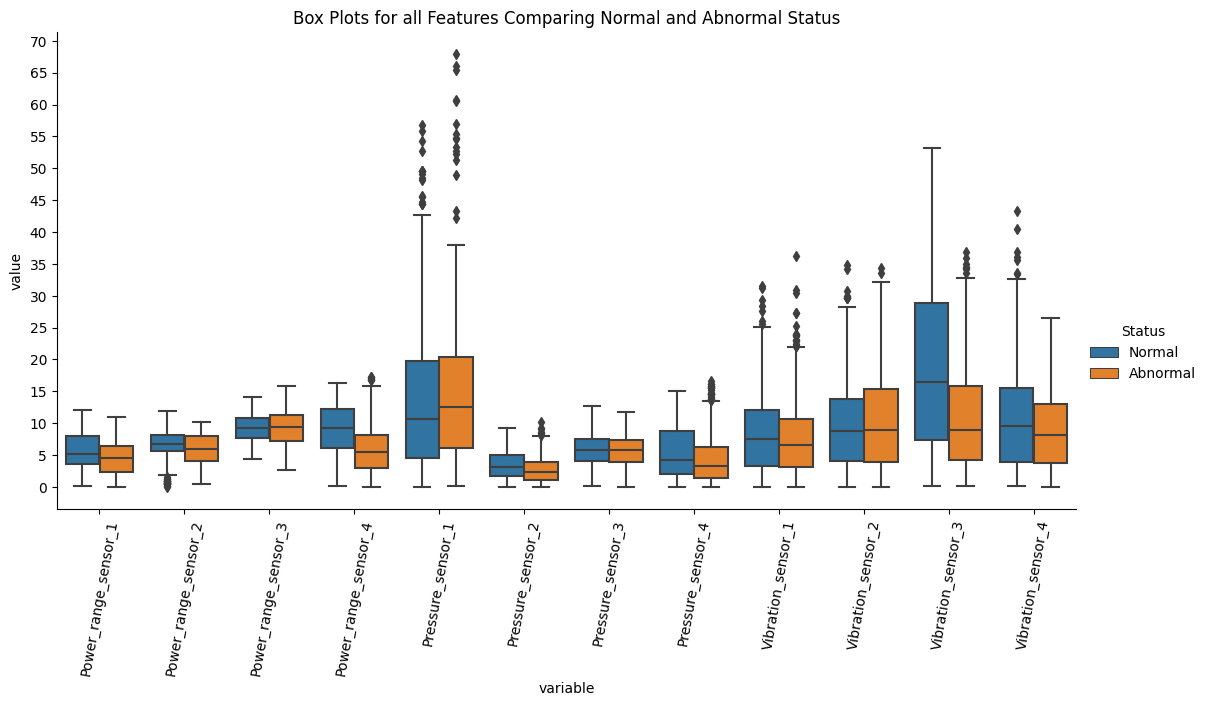

In [8]:
# Create box plots for all features for both groups (Status)
dfm = df_pandas.melt(id_vars='Status')

g = sns.catplot(kind='box', data=dfm, x='variable', y='value', hue='Status', height=5.5, aspect=2)

# Set xticks to rotate 90 degrees
g.set_xticklabels(rotation=80)

import numpy as np 

# Adjust yticks to be more readable (interval of 5)
plt.yticks(np.arange(0, 75, 5))

# Set a title for the plot
plt.title('Box Plots for all Features Comparing Normal and Abnormal Status')


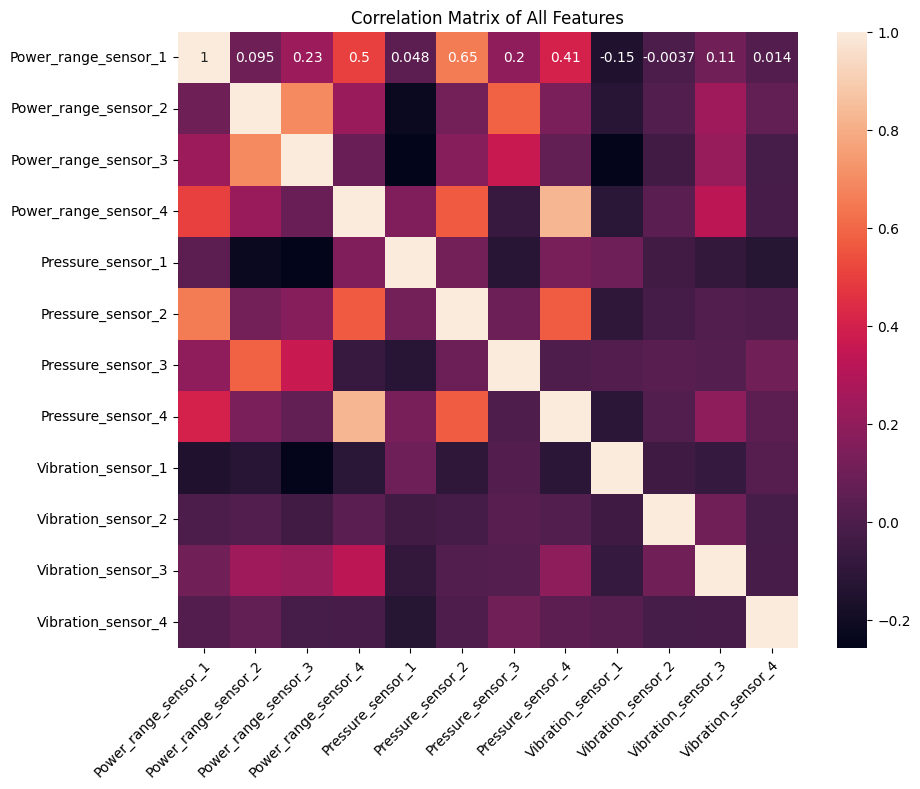

In [9]:
# Understand the relationship between features using a correlation matrix.

# Set the figure size
fig, ax = plt.subplots(figsize=(10,8))

# Create a correlation matrix of all the features in the main dataset (not split by status)
# We know that the "Status" column wont have much relevance in correlation matrix, so we can drop it
sns.heatmap(df_pandas.drop("Status", axis=1).corr(), annot=True)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Set the title for the plot
ax.set_title("Correlation Matrix of All Features")

# Display the plot
plt.show()